Here I'm going to explore the notification moduel and how they work. First, I need to understand their fields

In [1]:
import pandas as pd
from pandas.io.json import json_normalize
%matplotlib inline
from datetime import datetime, timedelta

# LOAD DOS DADOS

In [3]:
df = pd.read_csv("../../data/privacy_protected_data/cleaned_data.csv")

/home/bormann/anaconda3/envs/amadeus-analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (1,2,6,7,8,10,11,12,15,16,18,19,21,22,24,25,27,28,31,32,33,36,37,40,41,42,45,46,48,49,50,51,52,54,55,61,62,68,70,73,74,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,98,99,100,101,102,103,104,105,107,108,110,111,114,115,117,119,120,121,122,126,127,128,131,133,135,137,138,139,142,144,145,146,149,153,156) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
grades_df = pd.read_excel("../../data/raw_data/nota_provas.xls")

Estas são as datas onde as avaliação dos alunos que compõe a base ocorreram.

In [5]:
date_v1 = datetime(day=10, year=2018, month=12)
date_v2 = datetime(day=11, month=2, year=2019)
date_v3 = datetime(day=18, month=3, year=2019)

# EXPLORAÇÃO inicial

In [65]:
notifications_df = df[df["model"] == "notifications.notification"].dropna(axis=1, how="all")

In [66]:
notifications_df.shape

(61291, 13)

In [17]:
df["model"].value_counts()

log.log                             129228
sessions.session                     68970
notifications.notification           61291
mural.muralvisualizations            14916
questionary.useranswer                3638
banco_questoes.alternative            2064
chat.talkmessages                     1084
chat.chatvisualizations               1080
goals.mygoals                         1075
questionary.userquest                  865
fcm_django.fcmdevice                   610
banco_questoes.question                516
topics.resource                        462
pdf_file.pdffile                       409
chat.conversation                      273
subjects.tag                           240
users.user                             227
mural.comment                          201
django_cron.cronjoblog                 188
topics.topic                           154
mural.mural                            149
mural.subjectpost                      129
subjects.subject                       123
pendencies.

Uma notificação possui os seguintes campos no log:
1. meta: 
2. user: que coleta o id do user para qual a notificação foi enviada
3. Level: O nível da notificação está relacionado à tarefa que ela notifica sobre, este campo possui 4 valores mas somente 3 significados
    
    3.1 1,2: Significam que a tarefa está em dia 
    
    3.2 3: Significa que a tarefa está atrasada
    
    3.3 4: Significa que o prazo para realizar a tarefa já acabou
4. viewed: que possui valor de verdadeiro ou falso indicando se a notifcação foi vista ou não pelo usuário
5. creation_date: A data de criação daquela notificação
6. task: id da task que aquela notificação está associada

# Limpeza dos dados

é preciso extrair as colunas existentes dentro da coluna "fields", para isso, eu vou utilizar a função json_normalize, nativa do pandas.

In [10]:
def extract_flatten_dataframe(df, column, meta_list):
    df_fields = json_normalize(data=df[column], meta=meta_list)
    df_fields.index = df.index
    return df_fields.join(df, how="outer")

In [19]:
notifications_df["context.is_correct"].value_counts()

True    61291
Name: context.is_correct, dtype: int64

In [23]:
#notification_fields = json_normalize(data=notifications_df["fields"], meta=["meta", "task", "user", "level", "viewed", "creation_date"] )
#notification_fields.index = notifications_df.index
notifications_df = notifications_df.astype({"level": pd.CategoricalDtype()})
notifications_df["creation_date"] = pd.to_datetime(notifications_df["creation_date"])
#notification_df_flatted = notification_fields.join(notifications_df, how="outer")

In [24]:
notifications_df.dtypes

Unnamed: 0                     int64
active                          bool
all_students                    bool
context.is_correct              bool
creation_date         datetime64[ns]
level                       category
show_window                     bool
task                         float64
viewed                        object
visible                         bool
model                         object
pk                            object
dtype: object

In [26]:
notifications_df.sample(10)

,Unnamed: 0,active,all_students,context.is_correct,creation_date,level,show_window,task,viewed,visible,model,pk
83061,83061,True,True,True,2019-01-25,1.0,True,45.0,False,True,notifications.notification,15323
100331,100331,True,True,True,2019-02-17,3.0,True,21.0,False,True,notifications.notification,33479
115340,115340,True,True,True,2019-03-04,3.0,True,54.0,False,True,notifications.notification,48488
81685,81685,True,True,True,2019-01-23,3.0,True,18.0,True,True,notifications.notification,13871
92404,92404,True,True,True,2019-02-06,3.0,True,58.0,False,True,notifications.notification,25407
110369,110369,True,True,True,2019-02-27,3.0,True,125.0,False,True,notifications.notification,43517
110280,110280,True,True,True,2019-02-27,1.0,True,30.0,False,True,notifications.notification,43428
113058,113058,True,True,True,2019-03-02,3.0,True,66.0,False,True,notifications.notification,46206
103701,103701,True,True,True,2019-02-21,3.0,True,66.0,False,True,notifications.notification,36849
110824,110824,True,True,True,2019-02-28,3.0,True,107.0,False,True,notifications.notification,43972


In [13]:
notification_fields.dtypes

creation_date    datetime64[ns]
level                  category
meta                     object
task                      int64
user                      int64
viewed                     bool
dtype: object

Como dá pra ver o pandas não consegue inferir muito bem os data types das colunas, vou utilizar meu conhecimento sobre elas para colocar valores mais baratos e que correspondem melhor aos seus valores.m

# Logs

In [64]:
logs_df = df.loc[df["model"] == "log.log"].dropna(axis=1, how="all")
#log_meta_list = ["component", "context", "action", "resource", "user", "user_id", "user_email", "datetime"]
#logs_df = extract_flatten_dataframe(logs_default_df, "fields", log_meta_list)

In [30]:
logs_df["action"].value_counts()

view                         70763
access                       24007
watch                        16436
logout                        6303
answer                        4557
finish                        1630
create                        1376
send                          1209
update                         765
view_statistics                374
start                          316
view_history                   263
create_comment                 206
search                         160
submit                         143
create_post                    139
click                          123
cron                           119
delete                         101
participating                   56
participate                     46
initwebconference               44
delete_post                     35
set_goal                        23
delete_comment                   9
access_difficulties_modal        9
edit_post                        4
send_difficulties                3
edit_comment        

In [31]:
logs_df.loc[logs_df["action"] == "view"].component.value_counts()

resources             34593
topic                 12047
subject                8393
mural                  3705
chat                   3088
category               3050
pendencies             2954
mobile                 2903
General_Dashboard        16
Category_Dashboard       13
admin_log                 1
Name: component, dtype: int64

In [32]:
logs_df.columns

Index(['Unnamed: 0', '_my_subclass', 'action', 'active', 'all_students',
       'answer', 'begin_date', 'brief_description', 'categories', 'category',
       ...
       'user_id', 'user_one', 'user_permissions', 'user_quest', 'user_two',
       'value', 'viewed', 'visible', 'model', 'pk'],
      dtype='object', length=157)

# View Logs

In [33]:
view_logs_df = logs_df.loc[logs_df["action"] == "view"].dropna(axis=1, how="all")

In [34]:
view_logs_df.shape

(70763, 57)

In [35]:
view_logs_df.columns

Index(['Unnamed: 0', 'action', 'active', 'all_students', 'component',
       'context.bulletin_id', 'context.bulletin_name', 'context.bulletin_slug',
       'context.category_id', 'context.category_name', 'context.category_slug',
       'context.goals_id', 'context.goals_name', 'context.goals_slug',
       'context.is_correct', 'context.pdffile_id', 'context.pdffile_name',
       'context.pdffile_slug', 'context.post_id', 'context.post_space_id',
       'context.post_space_name', 'context.post_space_slug',
       'context.questionary_id', 'context.questionary_name',
       'context.questionary_slug', 'context.resource_id',
       'context.resource_name', 'context.resource_slug', 'context.search_by',
       'context.subject_id', 'context.subject_name', 'context.subject_slug',
       'context.talk_id', 'context.timestamp_end', 'context.timestamp_start',
       'context.topic_id', 'context.topic_name', 'context.topic_slug',
       'context.user_id', 'context.view_page', 'context.webconfer

# Watch Logs

In [36]:
watch_logs_df = logs_df.loc[logs_df["action"] == "watch"].dropna(axis=1, how="all")
watch_logs_df.shape

(16436, 27)

# Answer logs

In [37]:
answer_logs_df = logs_df.loc[logs_df["action"] == "answer"].dropna(axis=1, how="all")
answer_logs_df.shape

(4557, 20)

# Finish logs

In [38]:
finish_logs_df = logs_df.loc[logs_df["action"] == "finish"].dropna(axis=1, how="all")
finish_logs_df.shape

(1630, 30)

In [39]:
finish_logs_df.dtypes

Unnamed: 0                    int64
action                       object
active                         bool
all_students                   bool
component                    object
context.category_id         float64
context.category_name        object
context.category_slug        object
context.is_correct             bool
context.questionary_id      float64
context.questionary_name     object
context.questionary_slug     object
context.subject_id          float64
context.subject_name         object
context.subject_slug         object
context.timestamp_end       float64
context.timestamp_start     float64
context.topic_id            float64
context.topic_name           object
context.topic_slug           object
context.ytvideo_id          float64
context.ytvideo_name         object
context.ytvideo_slug         object
datetime                     object
resource                     object
show_window                    bool
user_id                     float64
visible                     

In [40]:
finish_logs_df.resource.value_counts()

ytvideo        974
questionary    656
Name: resource, dtype: int64

# Send logs

In [42]:
send_logs_df = logs_df.loc[logs_df["action"] == "send"].dropna(axis=1, how="all")
send_logs_df.shape

(1209, 19)

In [43]:
send_logs_df.columns

Index(['Unnamed: 0', 'action', 'active', 'all_students', 'component',
       'context.is_correct', 'context.post_id', 'context.subject_id',
       'context.subject_name', 'context.subject_slug', 'context.talk_id',
       'context.user_id', 'datetime', 'resource', 'show_window', 'user_id',
       'visible', 'model', 'pk'],
      dtype='object')

In [44]:
grades_df.columns

Index(['id_estudante', 'v1', 'v2'], dtype='object')

In [45]:
grades_df[grades_df["id_estudante"] == 11]

,id_estudante,v1,v2
0,11,0.0,0.0


In [46]:
send_logs_df.columns

Index(['Unnamed: 0', 'action', 'active', 'all_students', 'component',
       'context.is_correct', 'context.post_id', 'context.subject_id',
       'context.subject_name', 'context.subject_slug', 'context.talk_id',
       'context.user_id', 'datetime', 'resource', 'show_window', 'user_id',
       'visible', 'model', 'pk'],
      dtype='object')

In [47]:
send_logs_df.head(100)

,Unnamed: 0,action,active,all_students,component,context.is_correct,context.post_id,context.subject_id,context.subject_name,context.subject_slug,context.talk_id,context.user_id,datetime,resource,show_window,user_id,visible,model,pk
130684,130684,send,True,True,chat,True,NaN,NaN,NaN,NaN,1.0,2.0,2018-10-21T05:33:36.120Z,message,True,1.0,True,log.log,9
130687,130687,send,True,True,chat,True,NaN,NaN,NaN,NaN,1.0,1.0,2018-10-21T05:33:58.186Z,message,True,2.0,True,log.log,12
130695,130695,send,True,True,chat,True,NaN,NaN,NaN,NaN,1.0,2.0,2018-10-21T23:03:16.256Z,message,True,1.0,True,log.log,20
130775,130775,send,True,True,chat,True,NaN,NaN,NaN,NaN,1.0,2.0,2018-10-22T12:22:46.656Z,message,True,1.0,True,log.log,100
132307,132307,send,True,True,chat,True,NaN,4.0,Resistência dos Materiais I,resistencia-dos-materiais-i,2.0,3.0,2018-10-23T05:00:20.161Z,message,True,4.0,True,log.log,1632
132360,132360,send,True,True,chat,True,NaN,4.0,Resistência dos Materiais I,resistencia-dos-materiais-i,2.0,3.0,2018-10-23T05:23:03.557Z,message,True,4.0,True,log.log,1685
135981,135981,send,True,True,chat,True,NaN,4.0,Resistência dos Materiais I,resistencia-dos-materiais-i,2.0,3.0,2018-10-26T18:44:53.758Z,message,True,4.0,True,log.log,5306
135982,135982,send,True,True,chat,True,NaN,4.0,Resistência dos Materiais I,resistencia-dos-materiais-i,2.0,3.0,2018-10-26T18:44:58.058Z,message,True,4.0,True,log.log,5307
135983,135983,send,True,True,chat,True,NaN,4.0,Resistência dos Materiais I,resistencia-dos-materiais-i,2.0,3.0,2018-10-26T18:45:20.467Z,message,True,4.0,True,log.log,5308
136459,136459,send,True,True,chat,True,NaN,NaN,NaN,NaN,1.0,1.0,2018-10-27T02:53:47.018Z,message,True,2.0,True,log.log,5784


# Create logs

Create logs won't be useful because they are mostly related to the teacher and administrators.

In [48]:
create_logs_df = logs_df.loc[logs_df["action"] == "create"].dropna(axis=1, how="all")
create_logs_df.shape

(1376, 51)

# Resources

In [62]:
resources_df = df[df["model"] == "topics.resource"].dropna(axis=1, how="all")

In [63]:
resources_df.columns

Index(['Unnamed: 0', '_my_subclass', 'active', 'all_students',
       'brief_description', 'context.is_correct', 'create_date', 'groups',
       'last_update', 'name', 'order', 'show_window', 'slug', 'students',
       'tags', 'topic', 'visible', 'model', 'pk'],
      dtype='object')

In [64]:
resources_df._my_subclass.value_counts()

pdffile          109
ytvideo           18
webpage           18
questionary       11
goals              4
webconference      1
bulletin           1
Name: _my_subclass, dtype: int64

In [54]:
resources_df._my_subclass.value_counts()

pdffile        409
webpage         18
ytvideo         18
questionary     12
goals            3
bulletin         2
Name: _my_subclass, dtype: int64

# Pendências

In [60]:
pendencies_df = df[df["model"] == "pendencies.pendencies"].dropna(axis=1, how="all")

In [61]:
pendencies_df.dtypes

Unnamed: 0             int64
action                object
active                  bool
all_students            bool
begin_date            object
context.is_correct      bool
end_date              object
limit_date            object
resource              object
show_window             bool
visible                 bool
model                 object
pk                    object
dtype: object

In [59]:
pendencies_df.head(2)

,Unnamed: 0,action,active,all_students,begin_date,context.is_correct,end_date,resource,show_window,visible,model,pk
260891,260891,view,True,True,2018-11-06 03:00:00,True,2018-11-12T02:59:00Z,9,True,True,pendencies.pendencies,7
260892,260892,submit,True,True,2018-11-07 03:00:00,True,2018-11-12T02:59:00Z,159,True,True,pendencies.pendencies,8


In [21]:
# change pendencies data type to make easier to manipulate data and analyze as well
date_columns = ["begin_date", "end_date", "limit_date"]
for column in date_columns:
    #pendencies_df[column] = pendencies_df[column].apply(lambda date: pd.Timestamp(date, tz=None))
    pendencies_df[column] = pd.to_datetime(pendencies_df[column])
    pendencies_df[column] = pendencies_df[column].apply(lambda timestamp: timestamp.replace(tzinfo=None))


#pendencies_df[date_columns] = pd.to_datetime(pendencies_df[date_columns])
#pendencies_df[date_columns] = pd.Timestamp(pendencies_df[date_columns])

In [22]:
pendencies_df["action"] = pendencies_df["action"].astype("category")

In [23]:
pendencies_df.dtypes

action              category
begin_date    datetime64[ns]
end_date      datetime64[ns]
limit_date    datetime64[ns]
resource               int64
fields                object
model                 object
pk                    object
dtype: object

In [24]:
pendencies_df.head(2)

,action,begin_date,end_date,limit_date,resource,fields,model,pk
120708,view,2018-10-28 02:53:00,2018-10-28 02:55:00,NaT,163,"{'action': 'view', 'begin_date': '2018-10-28T0...",pendencies.pendencies,1
120709,view,2018-10-28 02:54:00,2018-10-31 02:54:00,NaT,164,"{'action': 'view', 'begin_date': '2018-10-28T0...",pendencies.pendencies,2


# Users Data
Como os usuários são o principal objeto de pesquisa deste relatório, eu preciso coletar os IDs deles para juntar as notificações e "dar à um responsável".

In [25]:
users_df = df[df["model"] == "users.user"]
users_df.head(2)

,fields,model,pk
34528,{'password': 'pbkdf2_sha256$30000$5DROf4Pf3BPR...,users.user,1
34529,{'password': 'pbkdf2_sha256$30000$u3Lg5la328P5...,users.user,2


In [26]:
users_df["fields"][34528]

{'password': 'pbkdf2_sha256$30000$5DROf4Pf3BPR$tPd1JbDlLqrUzoY/JcUSfparBrp7n0ERZKWgpfnbG/Y=',
 'last_login': '2019-01-22T12:36:36.447Z',
 'is_superuser': True,
 'email': 'admin@amadeus.br',
 'username': 'Administrador',
 'last_name': 'Geral',
 'social_name': None,
 'description': '',
 'image': '',
 'date_created': '2018-10-19T16:55:27.084Z',
 'last_update': '2018-11-04T03:31:13.036Z',
 'show_email': 1,
 'is_staff': True,
 'is_active': True,
 'groups': [],
 'user_permissions': []}

# Dicionário dos dados
1. Password: Senha criptografada
2. Last_Login: a última vez que o usuário logou no sistema
3. is_superuser: Significa que o usuário é um super usuário, tem privilégios ou admin.
4. email: e-mail pertecente ao usuário 
5. username: nome que o usuário quer que outros usuários o vejam
6. last_name: Sobrenome do usuário
7. social_name: Nome social que o usuário quer escolher para ser demonstrado 
8. description: ?
9. image: Caminho para a imagem do usuário
10. date_created: Data em que o usuário foi criado
11. last_update: a última vez que os dados do usuário foram modificados
12. show_email: Uma booleana que informa se o e-mail é visiível para outros usuários
13. is_staff: se ele é do tipo admin
14. is_active: Se o usuário está ativo, caso sim, ele pode entrar no sistema, senão, é impossível
15. groups: Grupos de permissão ao qual esse usuário pertence ("professor", "estudante"...)
16. user_permissions = permissões individuais que ele possui ("criar tópico" , "deletar tópico", "editar tópico")

In [27]:
# fields:  
user_fields = ["password", "last_login", "is_superuser", "email", "username", "last_name", "social_name", "description", 
               "imagem", "date_created", "last_update", "show_email", "is_staff", "is_active", "groups", "user_permissions"]

In [28]:
user_df_flatten = extract_flatten_dataframe(users_df, column="fields",meta_list=user_fields).astype({"pk": "int64"})

In [29]:
user_df_flatten.dtypes

date_created        object
description         object
email               object
groups              object
image               object
is_active             bool
is_staff              bool
is_superuser          bool
last_login          object
last_name           object
last_update         object
password            object
show_email           int64
social_name         object
user_permissions    object
username            object
fields              object
model               object
pk                   int64
dtype: object

# Notas dos alunos

In [30]:
grades_df.dtypes

id_estudante      int64
v1              float64
v2              float64
dtype: object

In [31]:
grades_df.head(10)

,id_estudante,v1,v2
0,11,0.0,0.00
1,12,4.0,7.00
2,13,6.5,7.50
3,14,6.5,10.00
4,15,6.0,8.50
5,16,6.0,3.50
6,17,0.5,4.00
7,18,1.5,7.25
8,19,7.5,8.50
9,20,2.0,9.75


# Vou remover as seguintes colunas:
1. Groups, pois não possui nenhum valor diferente de vazio (ou nulo).

In [32]:
user_df_flatten["groups"].value_counts()

[]    106
Name: groups, dtype: int64

In [33]:
user_df_flatten_clean = user_df_flatten.drop(["groups", "fields", "password"], axis=1)

# Junção entre os datasets
Para otimizar, irei coletar somente o username dos usuários durante o join com as notificações, depois eu irei buscar mais informações sobre eles.m

In [34]:
notifications_with_user_grades_df = pd.merge(notification_df_flatted, grades_df, left_on=["user"], right_on=["id_estudante"])

In [35]:
notifications_with_user_grades_df.head(10)

,creation_date,level,meta,task,user,viewed,fields,model,pk,id_estudante,v1,v2
0,2018-11-05,1,None,9,11,False,"{'meta': None, 'task': 9, 'user': 11, 'level':...",notifications.notification,105,11,0.0,0.0
1,2018-11-06,1,None,9,11,False,"{'meta': None, 'task': 9, 'user': 11, 'level':...",notifications.notification,195,11,0.0,0.0
2,2018-11-06,1,None,10,11,False,"{'meta': None, 'task': 10, 'user': 11, 'level'...",notifications.notification,261,11,0.0,0.0
3,2018-11-06,1,None,7,11,False,"{'meta': None, 'task': 7, 'user': 11, 'level':...",notifications.notification,338,11,0.0,0.0
4,2018-11-07,1,None,10,11,False,"{'meta': None, 'task': 10, 'user': 11, 'level'...",notifications.notification,463,11,0.0,0.0
5,2018-11-07,1,None,8,11,False,"{'meta': None, 'task': 8, 'user': 11, 'level':...",notifications.notification,574,11,0.0,0.0
6,2018-11-08,1,None,10,11,False,"{'meta': None, 'task': 10, 'user': 11, 'level'...",notifications.notification,682,11,0.0,0.0
7,2018-11-08,1,None,11,11,False,"{'meta': None, 'task': 11, 'user': 11, 'level'...",notifications.notification,756,11,0.0,0.0
8,2018-11-08,1,None,8,11,False,"{'meta': None, 'task': 8, 'user': 11, 'level':...",notifications.notification,844,11,0.0,0.0
9,2018-11-09,3,None,10,11,False,"{'meta': None, 'task': 10, 'user': 11, 'level'...",notifications.notification,927,11,0.0,0.0


# Análise
Primeiro eu vou explorar um pouco sobre a distribuição na quantiadde de notificações por usuário.

In [36]:
students_not_count_series = notifications_with_user_grades_df.groupby("user").size()

Com o grupo  de usuários que mais recebeu notificação e o grupo de usuários que menos recebeu notificações, eu vou tentar analisar qual a diferença disso e o rendimento comparado entre eles, irei colocar o 25% de cada. 

Existe um "lixo" nos dados que são os estudantes criados pelos adm, geralmente seu nomes são compostos por "Estudante X"

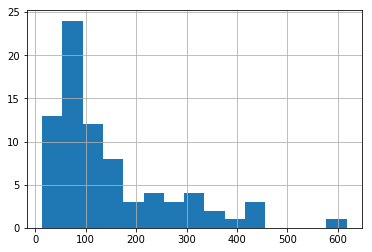

In [37]:
students_not_count_series.sort_values(ascending=False).hist(bins=15)

In [38]:
students_not_count_series.quantile([.1,.25, .5, .75, .9])

0.10     38.00
0.25     62.50
0.50    104.00
0.75    197.25
0.90    321.10
dtype: float64

Como da pra ver a distância é bem grande entre o 1ª quartil (.25) e o menores 10% assim como a distância é ainda mais grotesca com entre o 3ª quartil e o top 10%, quase o dobro de notificações recebidas.

## distribuição por nível de pendência
Os níveis de pendência variam entre 4 valores, sendo que o valor 1 e 2 representam o mesmo dado,
1. O valor 1 e 2 representam tarefas que ainda estão no prazo
2. O valor 3 representa tarefas que estão atrasadas
3. O valor 4 representa tarefas que não podem mais ser completadas/perdidas

In [39]:
notifications_with_user_grades_df.loc[notifications_with_user_grades_df["user"] == 14, ["v1", "v2"]].head(1)

,v1,v2
532,6.5,10.0


In [40]:
count_notification_level_by_user = notifications_with_user_grades_df.groupby(["user", "level"]).size()

In [41]:
count_notification_level_by_user.reset_index().pivot(index="user", columns="level", values=0).head(5)

level,1,2,3,4
user,,,,
11,71.0,NaN,179.0,95.0
12,45.0,NaN,2.0,NaN
13,58.0,NaN,39.0,43.0
14,23.0,NaN,7.0,43.0
15,64.0,NaN,76.0,43.0


# Indexando as notificações por tempo, análise temporal

In [42]:
notifications_with_user_grades_df.columns

Index(['creation_date', 'level', 'meta', 'task', 'user', 'viewed', 'fields',
       'model', 'pk', 'id_estudante', 'v1', 'v2'],
      dtype='object')

In [43]:
notifications_with_user_grades_df.index = notifications_with_user_grades_df["creation_date"]

In [44]:
notifications_with_user_grades_df.index

DatetimeIndex(['2018-11-05', '2018-11-06', '2018-11-06', '2018-11-06',
               '2018-11-07', '2018-11-07', '2018-11-08', '2018-11-08',
               '2018-11-08', '2018-11-09',
               ...
               '2019-01-04', '2019-01-13', '2019-01-14', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22'],
              dtype='datetime64[ns]', name='creation_date', length=11404, freq=None)

In [45]:
notifications_with_user_grades_df.resample('M').agg({"v1": "mean", "v2": "mean"})

,v1,v2
creation_date,,
2018-11-30,4.025120,4.690423
2018-12-31,3.089561,3.603879
2019-01-31,4.214038,4.814518


Dado muito bom: a média de notificações visualizadas e quantidade de notificações visualizadas por semana de cada usuário

In [46]:
notifications_with_user_grades_df.groupby(["user", pd.Grouper(freq="W")])\
.agg({"viewed": ["mean", "sum"]}).reset_index().head(2)

user creation_date viewed     
                       mean  sum
0   11    2018-11-11    0.0  0.0
1   11    2018-11-18    0.0  0.0

In [47]:
notifications_with_user_grades_df.groupby(["user", pd.Grouper(freq="M")])\
.agg({"viewed": ["mean", "sum"]}).reset_index().head(2)

user creation_date    viewed     
                          mean  sum
0   11    2018-11-30  0.058824  9.0
1   11    2018-12-31  0.073770  9.0

# Associar recurso à pendência

In [48]:
pendencies_df.columns

Index(['action', 'begin_date', 'end_date', 'limit_date', 'resource', 'fields',
       'model', 'pk'],
      dtype='object')

In [49]:
resources_flatten_df.columns

Index(['_my_subclass', 'all_students', 'brief_description', 'create_date',
       'groups', 'last_update', 'name', 'order', 'show_window', 'slug',
       'students', 'tags', 'topic', 'visible', 'model', 'pk'],
      dtype='object')

In [50]:
notifications_with_user_grades_df.columns

Index(['creation_date', 'level', 'meta', 'task', 'user', 'viewed', 'fields',
       'model', 'pk', 'id_estudante', 'v1', 'v2'],
      dtype='object')

In [51]:
pendencies_with_resources = pd.merge(pendencies_df, resources_flatten_df, left_on=["resource"], right_on=["pk"])

In [52]:
pendencies_with_resources.columns

Index(['action', 'begin_date', 'end_date', 'limit_date', 'resource', 'fields',
       'model_x', 'pk_x', '_my_subclass', 'all_students', 'brief_description',
       'create_date', 'groups', 'last_update', 'name', 'order', 'show_window',
       'slug', 'students', 'tags', 'topic', 'visible', 'model_y', 'pk_y'],
      dtype='object')

In [53]:
notications_with_resources_pendencies = pd.merge(notifications_with_user_grades_df, pendencies_with_resources, left_on=["task"], right_on=["pk_x"])

In [54]:
notications_with_resources_pendencies.shape

(11404, 36)

In [55]:
notications_with_resources_pendencies.dtypes

creation_date        datetime64[ns]
level                      category
meta                         object
task                         object
user                          int64
viewed                         bool
fields_x                     object
model                        object
pk                           object
id_estudante                  int64
v1                          float64
v2                          float64
action                     category
begin_date           datetime64[ns]
end_date             datetime64[ns]
limit_date           datetime64[ns]
resource                     object
fields_y                     object
model_x                      object
pk_x                         object
_my_subclass                 object
all_students                   bool
brief_description            object
create_date                  object
groups                       object
last_update                  object
name                         object
order                       

# Influência da notificação na V1

Para isto, só vou coletar notificações com pendências onde a data limite foi antes da data da v1

In [56]:
v1_notifications = notications_with_resources_pendencies[notications_with_resources_pendencies["end_date"] <= date_v1]\
.drop(columns=["v2"])
v1_notifications.index = v1_notifications["creation_date"]

In [57]:
v1_notifications.shape

(8408, 35)

Segundo a informação abaixo, pelo menos 75% possuem no mínimo 30 notificaçoes de pendências, e 50% possuem 71 notificações de pendências ou mais

In [58]:
v1_notifications.groupby("user").size().quantile([.1,.25, .5, .75, .9])

0.10     18.00
0.25     30.25
0.50     71.00
0.75    139.25
0.90    266.60
dtype: float64

In [59]:
v1_notifications.groupby(["user", pd.Grouper(freq="M")])\
.agg({"viewed": ["mean", "sum"]}).reset_index().head(2)

user creation_date    viewed     
                          mean  sum
0   11    2018-11-30  0.058824  9.0
1   11    2018-12-31  0.076923  9.0

In [60]:
test_df = v1_notifications.groupby(["user", pd.Grouper(freq="W")])\
.agg({"viewed": ["mean", "sum"]}).reset_index().head(10)

In [61]:
v1_notifications_viewed_date = v1_notifications.groupby(["user", pd.Grouper(freq="W")])\
.agg({"viewed": ["mean", "sum"]}).reset_index()

In [62]:
viewed_df = v1_notifications_viewed_date[["user", "creation_date"]]
viewed_df["mean"] = v1_notifications_viewed_date["viewed"]["mean"]
viewed_df["count"] = v1_notifications_viewed_date["viewed"]["sum"]

/home/bormann/anaconda3/envs/amadeus-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [63]:
def set_weeks_apart(df, date, date_column, week_diff_column):
    """
        Create a new column week_diff_column that contains the amount of weeks between the dates on the date_column
        of a given df to a related date
    """
    return df[date_column].apply(lambda dt: (dt - date).days//7)

In [64]:
set_weeks_apart(viewed_df, date_v1, "creation_date", "test")

0     -5
1     -4
2     -3
3     -2
4     -1
5      0
6      1
7      3
8      4
9      5
10     6
11    -5
12    -4
13    -3
14    -2
15    -5
16    -4
17    -3
18    -2
19    -1
20     0
21     1
22     3
23     4
24     5
25     6
26    -5
27    -4
28    -3
29    -2
      ..
549   -5
550   -4
551   -3
552   -2
553   -1
554    0
555    1
556    3
557    4
558    5
559    6
560   -5
561   -4
562   -3
563   -2
564   -1
565    0
566    1
567    3
568    4
569    5
570    6
571   -5
572   -4
573   -5
574   -4
575   -3
576   -2
577   -5
578   -4
Name: creation_date, Length: 579, dtype: int64

In [65]:
viewed_df.head(10)

,user,creation_date,mean,count
,,,,
0,11,2018-11-11,0.000000,0.0
1,11,2018-11-18,0.000000,0.0
2,11,2018-11-25,0.147541,9.0
3,11,2018-12-02,0.000000,0.0
4,11,2018-12-09,0.157895,9.0
5,11,2018-12-16,0.000000,0.0
6,11,2018-12-23,0.000000,0.0
7,11,2019-01-06,0.000000,0.0
8,11,2019-01-13,0.000000,0.0


In [66]:
v1_notifications_viewed_date[["user", "viewed"]]["viewed", "mean"]

0      0.000000
1      0.000000
2      0.147541
3      0.000000
4      0.157895
5      0.000000
6      0.000000
7      0.000000
8      0.000000
9      0.000000
10     0.000000
11     0.625000
12     0.714286
13     0.142857
14     0.200000
15     0.444444
16     0.562500
17     0.083333
18     0.545455
19     0.142857
20     0.000000
21     0.000000
22     0.000000
23     0.000000
24     0.000000
25     0.500000
26     0.333333
27     0.666667
28     0.600000
29     0.142857
         ...   
549    0.000000
550    0.000000
551    0.230769
552    0.000000
553    0.000000
554    0.000000
555    0.000000
556    0.000000
557    0.000000
558    0.000000
559    0.000000
560    0.285714
561    0.666667
562    0.571429
563    0.285714
564    0.428571
565    0.000000
566    1.000000
567    0.000000
568    0.000000
569    0.428571
570    0.000000
571    0.100000
572    0.625000
573    0.357143
574    0.687500
575    0.043478
576    0.266667
577    0.875000
578    0.333333
Name: (viewed, mean), Le

In [67]:
v1_notifications_viewed_date.columns

MultiIndex(levels=[['viewed', 'creation_date', 'user'], ['mean', 'sum', '']],
           codes=[[2, 1, 0, 0], [2, 2, 0, 1]])

In [68]:
v1_notifications_viewed_date.columns.get_level_values(1)

Index(['', '', 'mean', 'sum'], dtype='object')

In [69]:
v1_notifications["name"].value_counts()

Definição de metas da 1ª Etapa    1624
Aula 09 (Resumo)                   901
Aula 07 (Resumo)                   756
Aula 08 (Resumo)                   655
Simulado 02                        612
Aula 03                            594
Aula 06                            591
Aula 02                            577
Aula 05 (Resumo)                   517
Aula 04 (Resumo)                   493
Aula 01                            443
Simulado 01                        350
Avaliação Diagnóstica              295
Name: name, dtype: int64

In [70]:
v1_notifications[v1_notifications["name"].str.contains("Aula") & v1_notifications["viewed"]].shape

(877, 35)

In [71]:
v1_notifications[v1_notifications["name"].str.contains("Simulado")].shape

(962, 35)

In [72]:
v1_notifications["level"].value_counts()

3    4183
1    2472
4    1747
2       6
Name: level, dtype: int64

In [97]:
v1_notifications["simulado_delayed"] = v1_notifications["name"].str.contains("Simulado") & (v1_notifications["level"] == 3)
v1_notifications["simulado_incompleted"] = v1_notifications["name"].str.contains("Simulado") & (v1_notifications["level"] == 4)
v1_notifications["notes_delayed"] = v1_notifications["name"].str.contains("Aula") & (v1_notifications["level"] == 3)

In [ ]:
v1_notifications.groupby("user")

In [73]:
v1_notifications[v1_notifications["name"].str.contains("Simulado") & (v1_notifications["level"] == 3)].shape

(63, 35)

In [74]:
v1_notifications[v1_notifications["name"].str.contains("Simulado") & (v1_notifications["level"] == 4)].shape

(328, 35)

In [75]:
v1_notifications[v1_notifications["name"].str.contains("Simulado") & (v1_notifications["level"] == 1)].shape

(568, 35)

In [76]:
v1_notifications[v1_notifications["name"].str.contains("Aula") & (v1_notifications["level"] == 3)].shape

(3964, 35)

In [96]:
v1_notifications[v1_notifications["name"].str.contains("Aula") & (v1_notifications["level"] == 1)].shape

(1560, 37)